# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [1]:
# Installing Libraries
!pip install --upgrade pip
!pip install scikit-learn matplotlib Pillow

Requirement already up-to-date: pip in /home/ishita/anaconda3/lib/python3.6/site-packages (19.3.1)


In [2]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE


plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [3]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [4]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [5]:
# Loading the dataset
# eg.
# dirpath = './dataset/IMFDB/'
X_imfdb,y_imfdb = load_data('./dataset/IMFDB')
N,H,W, = X_imfdb.shape[0:3]
C = X_imfdb.shape[3]
N_imfdb,H_imfdb,W_imfdb = X_imfdb.shape[0:3]
C_imfdb = 1 if opt['is_grayscale'] else X_imfdb.shape[3]
X_cfw,y_cfw = load_data('./dataset/IIIT-CFW')
N_cfw,H_cfw,W_cfw = X_cfw.shape[0:3]
C_cfw = 1 if opt['is_grayscale'] else X_cfw.shape[3]
X_yale,y_yale = load_data('./dataset/Yale_face_database')
N_yale,H_yale,W_yale = X_yale.shape[0:3]
C_yale = 1 if opt['is_grayscale'] else X_yale.shape[3]

Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


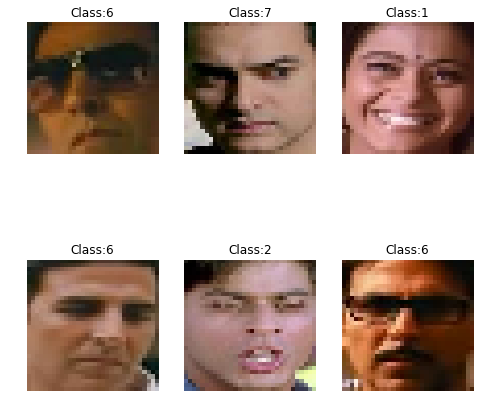

In [6]:
ind = np.random.randint(0,y_imfdb.shape[0],6)
disply_images(X_imfdb[ind,...],y_imfdb[ind], row=2,col=3)
y = y_imfdb
X = X_imfdb

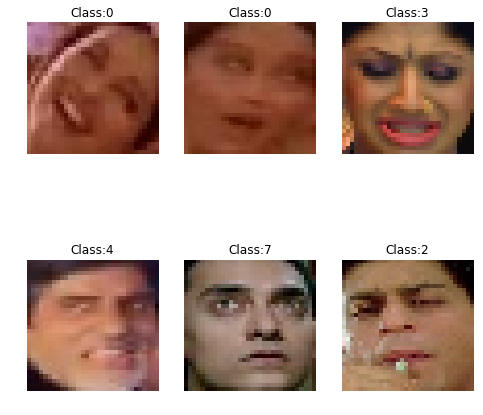

In [7]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [8]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

In [9]:
def reshape_data(X,N,H,W,C):
    X = X.reshape((N,H*W*C))
    return X

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [10]:
def get_pca(X_train,X_test,k=None):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k).fit(X_train)
    X_tr = pca.transform(X_train)
    X_te = pca.transform(X_test)
    return (X_tr,X_te)


###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [11]:
def get_kernel_pca(X_train,X_test, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree,fit_inverse_transform=True).fit(X_train)
    X_tr = kpca.transform(X_train)
    X_te = kpca.transform(X_test)
    return (X_tr,X_te)

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [12]:
def get_lda(X_train,X_test,y_train, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k).fit(X_train,y_train)
    X_tr = lda.transform(X_train)
    X_te = lda.transform(X_test)
    return (X_tr,X_te)

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [13]:
def get_kernel_lda(X_train,X_test,y_train,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X_train**degree
    elif kernel == "rbf":
        var = np.var(X_train)
        X_transformed= np.exp(-X_train/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X_train)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k).fit(X_transformed,y_train)
    X_tr = klda.transform(X_train)
    X_te = klda.transform(X_test)
    return (X_tr,X_te)

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [14]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [15]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 
Eigen faces are orthogonal basis set from which most of the faces of can be reconstructed. They are constructed by training on set of real faces. Each of the face highlight a certain type of feature. They are used in facial recognition and characterization applications.
___________________________

Your answers here (double click to edit)


1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

In [16]:
# Compute your features 
# eg.
X_imfdb = reshape_data(X_imfdb,N_imfdb,H_imfdb,W_imfdb,C_imfdb)
X_cfw = reshape_data(X_cfw,N_cfw,H_cfw,W_cfw,C_cfw)
X_yale = reshape_data(X_yale,N_yale,H_yale,W_yale,C_yale)
def calculate_eigen_vals(X,k):
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    x = np.arange(k)
    evals = pca.explained_variance_
    return X_k,x,evals

#X_3D = get_kernel_lda(X,y,None)

In [17]:
import warnings
warnings.filterwarnings("ignore")
from numpy import linalg as LA
def eigen_vect(arr):
    arr =  (arr-np.mean(arr))/(np.std(arr))
    cov_mat = np.cov(arr.T)
    eig_val,eig_vec = LA.eig(cov_mat)
    idx = np.argsort(-eig_val)
    val = np.cumsum(eig_val)
    x = 0
    for i in range(len(val)):
        if (val[i]*100)>=(95*val[-1]):
            return i
    
k_imfdb = eigen_vect(X_imfdb)
k_cfw = eigen_vect(X_cfw)
k_yale = eigen_vect(X_yale)
print(k_imfdb,k_cfw,k_yale)

123 308 61


In [18]:
X_3D1,x_axis1,evals_imfdb = calculate_eigen_vals(X_imfdb,k_imfdb)
X_3D2,x_axis2,evals_yale = calculate_eigen_vals(X_yale,k_yale)
X_3D3,x_axis3,evals_cfw = calculate_eigen_vals(X_cfw,k_cfw)


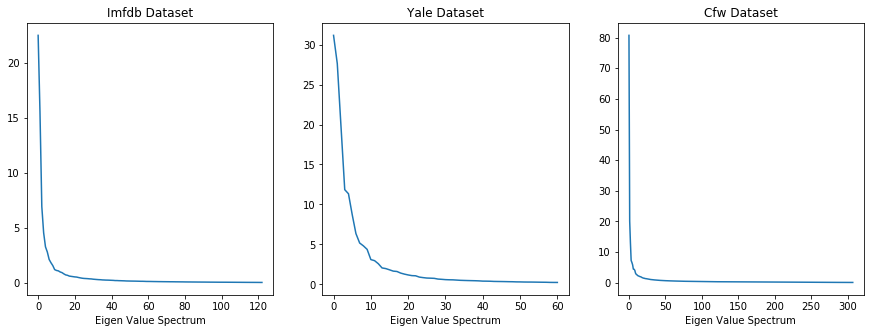

In [19]:
#Eigen Value Spectrum

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(x_axis1,evals_imfdb)
plt.xlabel("Eigen Value Spectrum")
plt.title("Imfdb Dataset")
plt.subplot(1,3,2)
plt.plot(x_axis2,evals_yale)
plt.xlabel("Eigen Value Spectrum")
plt.title("Yale Dataset")
plt.subplot(1,3,3)
plt.plot(x_axis3,evals_cfw)
plt.xlabel("Eigen Value Spectrum")
plt.title("Cfw Dataset")

plt.show()


Text(0.5,0.92,'CFW')

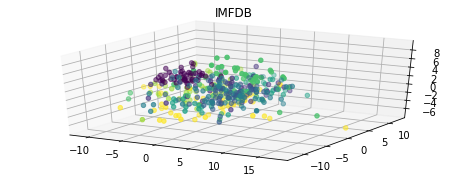

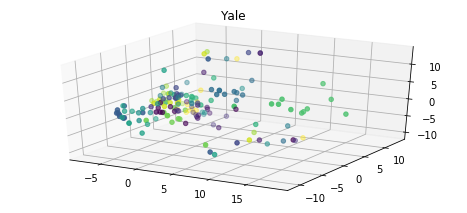

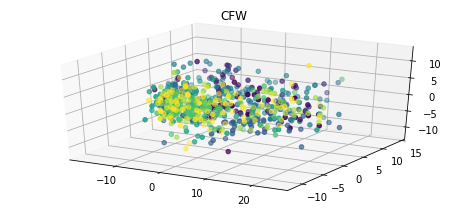

In [20]:
#Create a scatter plot  
#eg.
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(311, projection='3d')
ax.scatter(X_3D1[:,0],X_3D1[:,1],X_3D1[:,2],c=y_imfdb)
ax.set_title("IMFDB")

fig = plt.figure(figsize=(8,12))
ax1 = fig.add_subplot(312, projection='3d')
ax1.scatter(X_3D2[:,0],X_3D2[:,1],X_3D2[:,2],c=y_yale)
ax1.set_title("Yale")

fig = plt.figure(figsize=(8,12))
ax2 = fig.add_subplot(313, projection='3d')
ax2.scatter(X_3D3[:,0],X_3D3[:,1],X_3D3[:,2],c=y_cfw)
ax2.set_title("CFW")

1(c). Reconstruct  the  image  back for each case


In [21]:
# import matplotlib.image as mpimg
# imgplot = plt.imshow(img)
# plt.show()
def reshape_display(X_reconstructed,N,H,W,C):
    re_img = np.reshape(X_reconstructed,(N,H,W,C))
    return re_img
def reconstruct_images(X,N,H,W,C,y,k,string):
#         Reconstruct the images back by just using the selected principal components. 
#         print("PCA\n")
        ind = np.random.randint(0,y.shape[0],3)
        pca = PCA(n_components=k)
        X_k = pca.fit_transform(X)
        re_img = pca.inverse_transform(X_k)
        print("For "+string)
        print("Reconstruction Error")
        print(np.sqrt(np.mean((re_img-X)**2)))
        #normalised
        img1 = re_img
        re_img = (re_img-np.min(re_img))/(np.max(re_img)-np.min(re_img))
        img = (X-np.min(X))/(np.max(X)-np.min(X))
        re_img = np.reshape(re_img,(N,H,W,C))
        img = np.reshape(img,(N,H,W,C))
        disply_images(re_img[ind,...], y[ind], row=1,col=3)
        disply_images(img[ind,...], y[ind], row=1, col=3)
        return img1


For imfdb
Reconstruction Error
0.0387659094019173


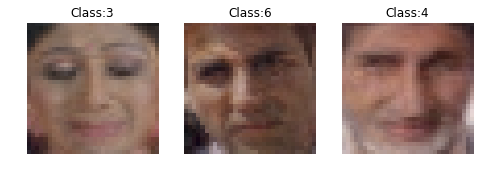

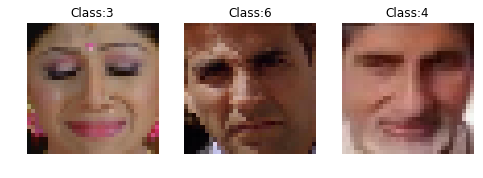

In [22]:
# Display results 

re_img_imfdb = reconstruct_images(X_imfdb,N_imfdb,H_imfdb,W_imfdb,C_imfdb,y_imfdb,k_imfdb,"imfdb")



For cfw
Reconstruction Error
0.06840967440069867


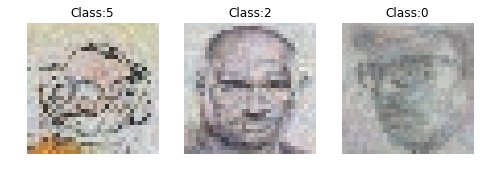

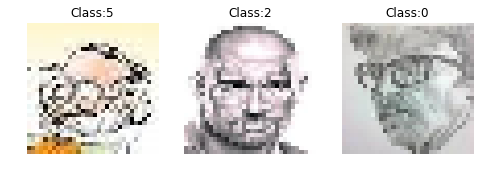

In [23]:

re_img_cfw = reconstruct_images(X_cfw,N_cfw,H_cfw,W_cfw,C_cfw,y_cfw,k_cfw,"cfw")

For yale
Reconstruction Error
0.05452064127483635


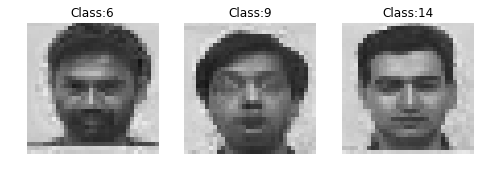

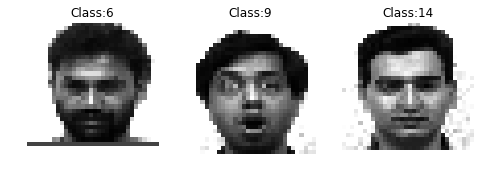

In [24]:

re_img_yale = reconstruct_images(X_yale,N_yale,H_yale,W_yale,C_yale,y_yale,k_yale,"yale")

In [25]:
print(np.shape(X_yale))

(165, 3072)


1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [26]:
# code goes here

max1 = -1
out = 0
print("IMFDB")
for i in range(8):
    re_data = re_img_imfdb[np.where(y_imfdb==i)]
    data = X_imfdb[np.where(y_imfdb==i)]
    ans = np.sqrt(np.mean((re_data-data)**2))
    if ans>max1:
        max1 = ans
        out = i
print(out,max1)

print("YALE")
max1 = -1
for i in range(15):
    re_data = re_img_yale[np.where(y_yale==i)]
    data = X_yale[np.where(y_yale==i)]
    ans = np.sqrt(np.mean((re_data-data)**2))
    if(ans>max1):
        max1 = ans
        out = i
print(out,max1)

print("CFW")
max1 = -1
for i in range(15):
    re_data = re_img_cfw[np.where(y_cfw==i)]
    data = X_cfw[np.where(y_cfw==i)]
    ans = np.sqrt(np.mean((re_data-data)**2))
    if(ans>max1):
        max1 = ans
        out = i
print(out,max1)
    
# disply_images(re_img[ind,...],y[ind], row=2,col=3)

IMFDB
2 0.040058125929236715
YALE
0 0.059672545545268664
CFW
4 0.07046415053842109


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [27]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.metrics import f1_score,confusion_matrix as CM,precision_score as PS,recall_score as RS
from sklearn.linear_model import LogisticRegression as LR
import pandas as pd
class Classifier():
    def __init__(self,classifier,feat,val,mat):
        iterations = 1000
        learning_rate = 0.001
        W = None 
        self.model_type = classifier
        self.k_imfdb = 180 
        self.feature = feat
        self.matrix = mat
        self.max1 = val
        if classifier == "SVM":
            self.model = SVC()
        elif classifier == "MLP":
            self.model = MLP()
        elif classifier == "LR":
            self.model = LR()
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        prediction = self.model.predict(X)
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        cm = CM(y,pred)
        self.err = 0
        return cm
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label
            @return Nothing
        """ 
        if self.model_type == "SVM":
            self.model = SVC(kernel = 'linear', C = 200).fit(X_train, y_train) 
        elif self.model_type == "MLP":
            self.model = MLP(hidden_layer_sizes=(450,450)).fit(X_train,y_train)
        else:
            self.model = LR(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)
        self.err = self.model.score(X_train,y_train)
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        accuracy = self.model.score(X_validate,y_validate)
        y_pred = self.classify(X_validate)
        f1score = f1_score(y_validate,y_pred,average='macro')
        cm = self.confusion_matrix(y_validate,y_pred)
        precision = PS(y_validate,y_pred,average='macro')
        recall = RS(y_validate,y_pred,average='macro')
        print(accuracy*100,f1score,precision,recall)
        f = {}
        if self.max1<(accuracy*100):
            self.max1 = accuracy*100
            self.matrix = cm
        type_model = self.feature+'+'+self.model_type
        
        f = {"model_type":type_model,"accuracy":accuracy*100,"reduced_space":np.shape(X_validate)[1],"f1-score":f1score,"training error":self.err}
        ans.append(f)
        

        # Create a confusion matrix
        
        # Calculate Validation accuracy 
    
        # Calculate precision and recall 
        
        # Calculate F1-score
    
        return self.matrix,self.max1

In [28]:
#for imfdb dataset
pca = get_pca(X_imfdb,k_imfdb)
print(np.shape(pca))
print(np.shape(X_imfdb))

(2,)
(400, 3072)


In [29]:
# Create a train and validation split to train your classifier


In [30]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

# Print the table. (You can use Pandas)


In [31]:
from sklearn.model_selection import train_test_split
def feature_extraction(X_data,labels,k,string):
    print(string)
    X_train, X_test, y_train, y_test = train_test_split(X_data, labels, test_size=0.20, random_state=42)
    pca_tr,pca_te = get_pca(X_train,X_test,k)
    kpca_tr,kpca_te = get_kernel_pca(X_train,X_test,k)
    lda_kpca_tr,lda_kpca_te = get_lda(kpca_tr,kpca_te,y_train,k)
    lda_pca_tr,lda_pca_te = get_lda(pca_tr,pca_te,y_train,k)
    klda_kpca_tr,klda_kpca_te = get_kernel_lda(kpca_tr,kpca_te,y_train,k,"sigmoid")
    klda_pca_tr,klda_pca_te = get_kernel_lda(pca_tr,pca_te,y_train,k)
    if string =="IMFDB":
        vgg = get_vgg_features('./dataset/IMFDB')
        resnet = get_resnet_features('./dataset/IMFDB')
    elif string == "YALE":
        vgg = get_vgg_features('./dataset/Yale_face_database')
        resnet = get_resnet_features('./dataset/Yale_face_database')
    elif string == "CFW":
        vgg = get_vgg_features('./dataset/IIIT-CFW')
        resnet = get_resnet_features('./dataset/IIIT-CFW')
    return  y_train,y_test,pca_tr,pca_te,kpca_tr,kpca_te,lda_kpca_tr,lda_kpca_te,lda_pca_tr,lda_pca_te,klda_kpca_tr,klda_kpca_te,klda_pca_tr,klda_pca_te,vgg,resnet

    
        

    

In [32]:
def run_model(X_train,X_test,y_train,y_test,string,max1,cm_mat):
    print(string)
    print("SVM")
    svm = Classifier("SVM",string,max1,cm_mat)
    svm.train(X_train,y_train)
    cm_mat,max1 = svm.validate(X_test,y_test)
    print("MLP")
    mlp = Classifier("MLP",string,max1,cm_mat)
    mlp.train(X_train,y_train)
    cm_mat,max1 = mlp.validate(X_test,y_test)
    print("LR")
    lr = Classifier("LR",string,max1,cm_mat)
    lr.train(X_train,y_train)
    cm_mat,max1 = lr.validate(X_test,y_test)
    print(cm_mat,max1)
    return cm_mat,max1


In [33]:
#imfdb
y_train,y_test,pca_tr,pca_te,kpca_tr,kpca_te,lda_kpca_tr,lda_kpca_te,lda_pca_tr,lda_pca_te,klda_kpca_tr,klda_kpca_te,klda_pca_tr,klda_pca_te,vgg,resnet =feature_extraction(X_imfdb,y_imfdb,k_imfdb,"IMFDB")
vgg_resnet = np.concatenate((vgg,resnet),axis=1)
np.shape(vgg_resnet)



IMFDB


(400, 6144)

In [34]:
ans = []
max1 = -1
vgg_tr,vgg_te,vy_train,vy_test = train_test_split(vgg, y_imfdb, test_size=0.20, random_state=42)
resnet_tr,resnet_te,res_y_train,res_y_test = train_test_split(resnet, y_imfdb, test_size=0.20, random_state=42)
vgg_resnet_tr,vgg_resnet_te,vres_y_train,vres_y_test = train_test_split(vgg_resnet, y_imfdb, test_size=0.20, random_state=42)
sz = len(set(y_imfdb))
cm_mat = np.zeros((sz,sz))
cm_mat,max1 = run_model(pca_tr,pca_te,y_train,y_test,"PCA",max1,cm_mat)
cm_mat,max1 = run_model(kpca_tr,kpca_te,y_train,y_test,"KPCA",max1,cm_mat)
cm_mat,max1 = run_model(lda_kpca_tr,lda_kpca_te,y_train,y_test,"LDA+KPCA",max1,cm_mat)
cm_mat,max1 = run_model(lda_pca_tr,lda_pca_te,y_train,y_test,"LDA+PCA",max1,cm_mat)
cm_mat,max1 = run_model(klda_kpca_tr,klda_kpca_te,y_train,y_test,"KLDA+KPCA",max1,cm_mat)
cm_mat,max1 = run_model(klda_pca_tr,klda_pca_te,y_train,y_test,"KLDA+PCA",max1,cm_mat)
cm_mat,max1 = run_model(vgg_tr,vgg_te,vy_train,vy_test,"VGG",max1,cm_mat)
cm_mat,max1 = run_model(resnet_tr,resnet_te,res_y_train,res_y_test,"RESNET",max1,cm_mat)
cm_mat,max1 = run_model(vgg_resnet_tr,vgg_resnet_te,vres_y_train,vres_y_test,"VGG+RESNET",max1,cm_mat)
cm_mat_imfdb = cm_mat
max1_imfdb = max1
ans_imfdb = ans

PCA
SVM
82.5 0.8191836935443073 0.81680506993007 0.8433753746253747
MLP
83.75 0.8356846829640947 0.8507395382395382 0.8590003746253747
LR
82.5 0.8179633289415899 0.822492784992785 0.8436563436563438
[[10  0  0  0  0  0  0  1]
 [ 0  6  0  5  1  1  1  0]
 [ 0  1  5  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  1]
 [ 0  0  0  0 10  0  0  0]
 [ 0  0  0  2  0  7  0  0]
 [ 0  0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0  0 11]] 83.75
KPCA
SVM
85.0 0.8435008618832148 0.8393294205794206 0.8626061438561439
MLP
82.5 0.8135522688096217 0.8082372488622489 0.8373657592407593
LR
40.0 0.35338915470494425 0.46163949275362315 0.4894792707292707
[[10  0  0  0  0  0  0  0]
 [ 0  6  0  2  1  0  1  0]
 [ 0  1  5  1  0  0  0  0]
 [ 0  0  0  8  0  2  0  1]
 [ 0  0  0  0 10  0  0  0]
 [ 0  0  0  2  0  6  0  0]
 [ 0  0  0  0  0  0 12  1]
 [ 0  0  0  0  0  0  0 11]] 85.0
LDA+KPCA
SVM
78.75 0.7772262587076155 0.7887858669108669 0.7975618131868132
MLP
81.25 0.8057976242758851 0.8096955128205129 0.8190247252747253
LR
80.0 0

In [35]:
#yale
y_train,y_test,pca_tr,pca_te,kpca_tr,kpca_te,lda_kpca_tr,lda_kpca_te,lda_pca_tr,lda_pca_te,klda_kpca_tr,klda_kpca_te,klda_pca_tr,klda_pca_te,vgg,resnet =feature_extraction(X_yale,y_yale,k_yale,"YALE")
vgg_resnet = np.concatenate((vgg,resnet),axis=1)
np.shape(vgg_resnet)


YALE


(165, 6144)

In [36]:
ans = []
max1 = -1
vgg_tr,vgg_te,vy_train,vy_test = train_test_split(vgg, y_yale, test_size=0.20, random_state=42)
resnet_tr,resnet_te,res_y_train,res_y_test = train_test_split(resnet, y_yale, test_size=0.20, random_state=42)
vgg_resnet_tr,vgg_resnet_te,vres_y_train,vres_y_test = train_test_split(vgg_resnet, y_yale, test_size=0.20, random_state=42)
sz = len(set(y_yale))
cm_mat = np.zeros((sz,sz))
cm_mat,max1 = run_model(pca_tr,pca_te,y_train,y_test,"PCA",max1,cm_mat)
cm_mat,max1 = run_model(kpca_tr,kpca_te,y_train,y_test,"KPCA",max1,cm_mat)
cm_mat,max1 = run_model(lda_kpca_tr,lda_kpca_te,y_train,y_test,"LDA+KPCA",max1,cm_mat)
cm_mat,max1 = run_model(lda_pca_tr,lda_pca_te,y_train,y_test,"LDA+PCA",max1,cm_mat)
cm_mat,max1 = run_model(klda_kpca_tr,klda_kpca_te,y_train,y_test,"KLDA+KPCA",max1,cm_mat)
cm_mat,max1 = run_model(klda_pca_tr,klda_pca_te,y_train,y_test,"KLDA+PCA",max1,cm_mat)
cm_mat,max1 = run_model(vgg_tr,vgg_te,vy_train,vy_test,"VGG",max1,cm_mat)
cm_mat,max1 = run_model(resnet_tr,resnet_te,res_y_train,res_y_test,"RESNET",max1,cm_mat)
cm_mat,max1 = run_model(vgg_resnet_tr,vgg_resnet_te,vres_y_train,vres_y_test,"VGG+RESNET",max1,cm_mat)
cm_mat_yale = cm_mat
max1_yale = max1
ans_yale = ans

PCA
SVM
90.9090909090909 0.8683673469387755 0.8571428571428571 0.9107142857142857
MLP
78.78787878787878 0.7336734693877551 0.7785714285714285 0.7916666666666666
LR
96.96969696969697 0.9619047619047619 0.9761904761904762 0.9642857142857143
[[2 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3]] 96.96969696969697
KPCA
SVM
90.9090909090909 0.8683673469387755 0.8571428571428571 0.9107142857142857
MLP
96.96969696969697 0.9619047619047619 0.9761904761904762 0.9642857142857143
LR
33.33333333333333 0.3523809523809523 0.4185185185185185 0.42444444444444446
[[2 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0

In [37]:
##CFW
y_train,y_test,pca_tr,pca_te,kpca_tr,kpca_te,lda_kpca_tr,lda_kpca_te,lda_pca_tr,lda_pca_te,klda_kpca_tr,klda_kpca_te,klda_pca_tr,klda_pca_te,vgg,resnet =feature_extraction(X_cfw,y_cfw,k_cfw,"CFW")
vgg_resnet = np.concatenate((vgg,resnet),axis=1)
np.shape(vgg_resnet)


CFW


(672, 6144)

In [38]:
ans = []
max1 = -1
vgg_tr,vgg_te,vy_train,vy_test = train_test_split(vgg, y_cfw, test_size=0.20, random_state=42)
resnet_tr,resnet_te,res_y_train,res_y_test = train_test_split(resnet, y_cfw, test_size=0.20, random_state=42)
vgg_resnet_tr,vgg_resnet_te,vres_y_train,vres_y_test = train_test_split(vgg_resnet, y_cfw, test_size=0.20, random_state=42)
sz = len(set(y_cfw))
cm_mat = np.zeros((sz,sz))
cm_mat,max1 = run_model(pca_tr,pca_te,y_train,y_test,"PCA",max1,cm_mat)
cm_mat,max1 = run_model(kpca_tr,kpca_te,y_train,y_test,"KPCA",max1,cm_mat)
cm_mat,max1 = run_model(lda_kpca_tr,lda_kpca_te,y_train,y_test,"LDA+KPCA",max1,cm_mat)
cm_mat,max1 = run_model(lda_pca_tr,lda_pca_te,y_train,y_test,"LDA+PCA",max1,cm_mat)
cm_mat,max1 = run_model(klda_kpca_tr,klda_kpca_te,y_train,y_test,"KLDA+KPCA",max1,cm_mat)
cm_mat,max1 = run_model(klda_pca_tr,klda_pca_te,y_train,y_test,"KLDA+PCA",max1,cm_mat)
cm_mat,max1 = run_model(vgg_tr,vgg_te,vy_train,vy_test,"VGG",max1,cm_mat)
cm_mat,max1 = run_model(resnet_tr,resnet_te,res_y_train,res_y_test,"RESNET",max1,cm_mat)
cm_mat,max1 = run_model(vgg_resnet_tr,vgg_resnet_te,vres_y_train,vres_y_test,"VGG+RESNET",max1,cm_mat)
cm_mat_cfw = cm_mat
max1_cfw = max1
ans_cfw = ans

PCA
SVM
51.85185185185185 0.5221499468273662 0.5379628722570533 0.522618345930703
MLP
50.37037037037037 0.494131908072579 0.4959253508166552 0.5081224140720708
LR
53.333333333333336 0.5255142980341634 0.5268118565550653 0.5265512678270116
[[ 4  1  1  2  0  0  0  0]
 [ 1  4  0  3  1  0  0  0]
 [ 0  0  8  3  3  2  0  3]
 [ 3  1  1 21  1  2  0  2]
 [ 1  3  3  1 10  0  1  3]
 [ 0  0  0  0  1  7  0  5]
 [ 0  0  1  0  1  0  9  1]
 [ 0  0  5  0  2  4  1  9]] 53.333333333333336
KPCA
SVM
51.85185185185185 0.522789117395417 0.5290088383838384 0.5353708711832281
MLP
48.888888888888886 0.47067682561103613 0.4665736031254607 0.4943652774888473
LR
41.48148148148148 0.3504222615479652 0.36254014802401896 0.39692837990892915
[[ 4  1  1  2  0  0  0  0]
 [ 1  4  0  3  1  0  0  0]
 [ 0  0  8  3  3  2  0  3]
 [ 3  1  1 21  1  2  0  2]
 [ 1  3  3  1 10  0  1  3]
 [ 0  0  0  0  1  7  0  5]
 [ 0  0  1  0  1  0  9  1]
 [ 0  0  5  0  2  4  1  9]] 53.333333333333336
LDA+KPCA
SVM
44.44444444444444 0.438078061784

In [39]:
# import warnings
# warnings.filterwarning('ignore')


In [40]:
from operator import itemgetter
import pandas as pd
import random

In [41]:
def print_table(ans):
    newlist = sorted(ans, key=itemgetter('accuracy'),reverse=True) 
    data = []
    for i in range(len(newlist)):
        cur = list(newlist[i].values())
        data.append(cur)
    final_data = []
    x = random.sample(range(0,len(data)),9)
    for i in range(len(data)):
        final_data.append(data[i])
    final_data.append(data[-1])   
    df = pd.DataFrame(final_data,columns=['Model,Feature','Accuracy','Reduced Space','f1-score','training error'])
    print(df)

In [42]:
print("Imfdb Dataset")
print_table(ans_imfdb)
print("Yale Dataset")
print_table(ans_yale)
print("CFW dataSet")
print_table(ans_cfw)

Imfdb Dataset
     Model,Feature  Accuracy  Reduced Space  f1-score  training error
0   VGG+RESNET+MLP     97.50           6144  0.977037               0
1    VGG+RESNET+LR     97.50           6144  0.977037               0
2   VGG+RESNET+SVM     96.25           6144  0.963166               0
3       RESNET+SVM     95.00           2048  0.951161               0
4       RESNET+MLP     93.75           2048  0.934250               0
5        RESNET+LR     93.75           2048  0.936227               0
6           VGG+LR     91.25           4096  0.916677               0
7          VGG+SVM     90.00           4096  0.891109               0
8          VGG+MLP     86.25           4096  0.863792               0
9         KPCA+SVM     85.00            123  0.843501               0
10         PCA+MLP     83.75            123  0.835685               0
11      LDA+PCA+LR     83.75              7  0.831803               0
12         PCA+SVM     82.50            123  0.819184               0
13    

In [43]:
print("IMFDB")
print("Confusion Matrix")
print(cm_mat_imfdb)
print("Accuracy")
print(max1_imfdb)

print("YALE")
print("Confusion Matrix")
print(cm_mat_yale)
print("Accuracy")
print(max1_yale)

print("IIIT_CFW")
print("Confusion Matrix")
print(cm_mat_cfw)
print("Accuracy")
print(max1_cfw)
# For each dataset print the confusion matrix for the best model 

IMFDB
Confusion Matrix
[[10  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  1]
 [ 0  0  5  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0]
 [ 0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0  8  0  0]
 [ 0  0  0  1  0  0 13  0]
 [ 0  0  0  0  0  0  0 12]]
Accuracy
97.5
YALE
Confusion Matrix
[[2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3]]
Accuracy
100.0
IIIT_CFW
Confusion Matrix
[[ 9  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0]
 [ 0  0  1  0 18  0  0  0]
 [ 0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 11  0]
 [ 0  0  0  0  1  0  0 23]]
Accuracy
98.51851851851852


3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

In [18]:
# Compute TSNE for different features and create a scatter plot

def pca_tnse(X,y,k):
    pca = PCA(n_components=k).fit_transform(X)
    return pca
def kpca_tnse(X,k,kernel='rbf', degree=3):
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree,fit_inverse_transform=True)
    X_k = kpca.fit_transform(X)
    return (X_k)
def lda_tnse(X,y, k):
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k
def klda_tnse(X,y,k,kernel='rbf',degree=3):
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X_transformed,y)
    return X_k
def compute_TNSE(X,y,k,string):
    X_TSNE = TSNE(n_components=k).fit_transform(X)
    if k==2:
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        ax.scatter(X_TSNE[:,0],X_TSNE[:,1],c=y)
        title = string+"Data projection on 2D"
        ax.set_title(title)
    else:
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=y)
        title = string+"Data projection on 3D"
        ax.set_title(title)
        


# Plot the representation in 2d/3d


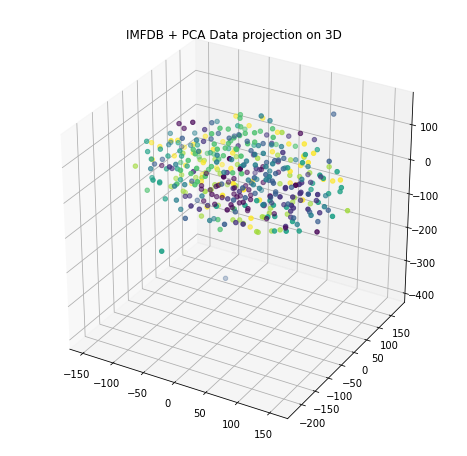

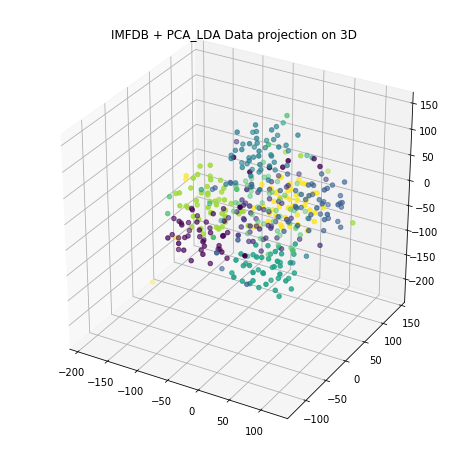

In [19]:
pca = pca_tnse(X_imfdb,y_imfdb,k_imfdb)
lda = lda_tnse(pca,y_imfdb,k_imfdb)
compute_TNSE(pca,y_imfdb,3,"IMFDB + PCA ")
compute_TNSE(lda,y_imfdb,3,"IMFDB + PCA_LDA ")


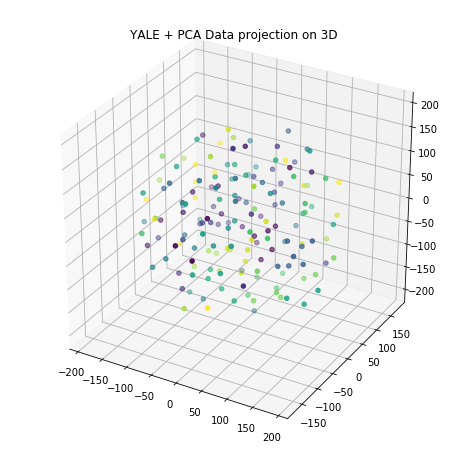

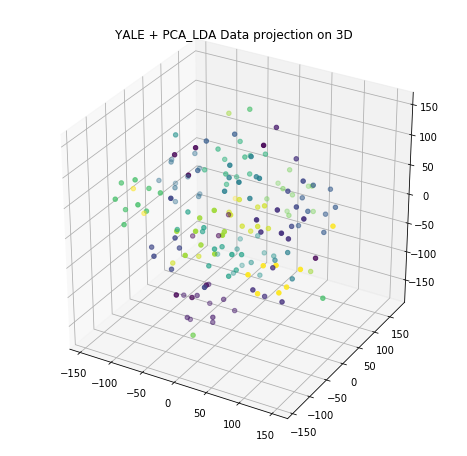

In [20]:
pca = pca_tnse(X_yale,y_yale,k_yale)
lda = lda_tnse(pca,y_yale,k_yale)
compute_TNSE(pca,y_yale,3,"YALE + PCA ")
compute_TNSE(lda,y_yale,3,"YALE + PCA_LDA ")

(1237, 3072)
(1237,)


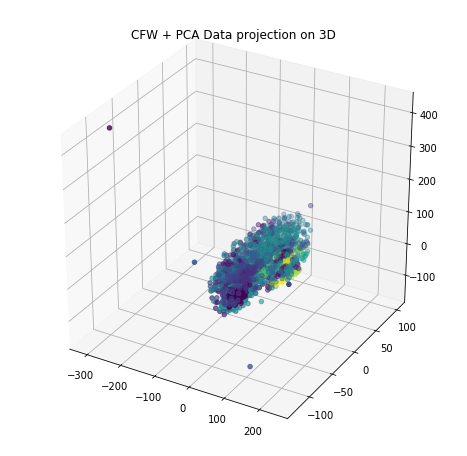

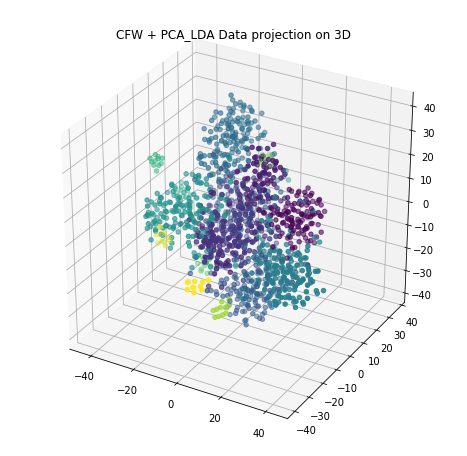

In [26]:
dataset = np.concatenate((np.concatenate((X_cfw,X_yale)),X_imfdb))
print(np.shape(dataset))
lb = np.concatenate((np.concatenate((y_cfw,y_yale)),y_imfdb))
print(np.shape(lb))
pca = pca_tnse(dataset,lb,400)
lda = lda_tnse(pca,lb,400)
compute_TNSE(pca,lb,3,"CFW + PCA ")
compute_TNSE(lda,lb,3,"CFW + PCA_LDA ")

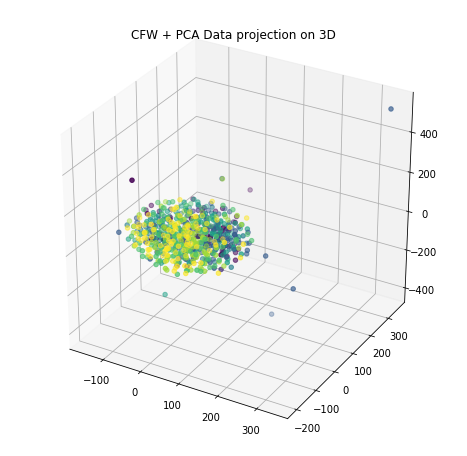

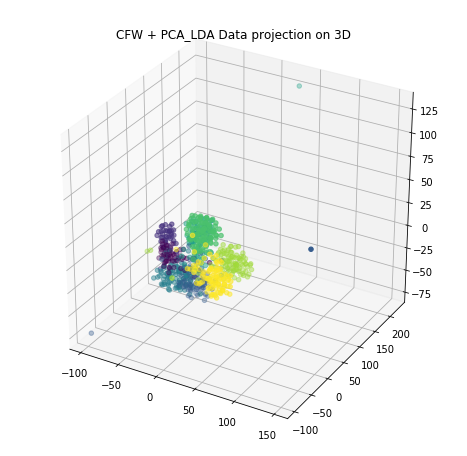

In [22]:
pca = pca_tnse(X_cfw,y_cfw,k_cfw)
lda = lda_tnse(pca,y_cfw,k_cfw)
compute_TNSE(pca,y_cfw,3,"CFW + PCA ")
compute_TNSE(lda,y_cfw,3,"CFW + PCA_LDA ")

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [48]:
from sklearn.neighbors import KNeighborsClassifier as KNN 
class FaceVerification():
    def __init__(self,string,k):
        self.knn = KNN()
        self.model_type = string
        self.ne = k
        self.err = 0
    # Define your parameters eg, W,b, max_iterations etc. 
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        prediction = self.knn.predict(X)
        verification_results = []
        for i in range(len(class_id)):
            if prediction[i]==class_id[i]:
                verification_results.append(True)
            else:
                verification_results.append(False)
        return verification_results
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.knn = KNN(n_neighbors=self.ne).fit(X_train,y_train) 
        self.err = self.knn.score(X_train,y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        accuracy = ((self.verify(X_validate,y_validate)).count(True))/(len(X_validate))
        y_pred = self.knn.predict(X_validate)
        precision = PS(y_validate,y_pred,average='macro')
        print(accuracy*100,precision)
        f = {"model_type":self.model_type+','+str(self.ne),"accuracy":accuracy*100,"reduced_space":np.shape(X_validate)[1],"precision":precision,"training_error":self.err}
        ans.append(f)
        return 

In [49]:
# Create a train and validation split and show your results 
k_values = [3,5,9]
def run_knn(X_train,X_test,y_train,y_test,string,k):
    print(string)
    knn1 = FaceVerification(string,k)
    knn1.train(X_train,y_train)
    knn1.validate(X_test,y_test)
    
    
    

In [50]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision
#imfdb
ans = []
y_train,y_test,pca_tr,pca_te,kpca_tr,kpca_te,lda_kpca_tr,lda_kpca_te,lda_pca_tr,lda_pca_te,klda_kpca_tr,klda_kpca_te,klda_pca_tr,klda_pca_te,vgg,resnet =feature_extraction(X_imfdb,y_imfdb,k_imfdb,"IMFDB")
vgg_resnet = np.concatenate((vgg,resnet),axis=1)
vgg_tr,vgg_te,vy_train,vy_test = train_test_split(vgg, y_imfdb, test_size=0.20, random_state=42)
resnet_tr,resnet_te,res_y_train,res_y_test = train_test_split(resnet, y_imfdb, test_size=0.20, random_state=42)
vgg_resnet_tr,vgg_resnet_te,vres_y_train,vres_y_test = train_test_split(vgg_resnet, y_imfdb, test_size=0.20, random_state=42)
for k in k_values:
    run_knn(pca_tr,pca_te,y_train,y_test,"PCA",k)
    run_knn(kpca_tr,kpca_te,y_train,y_test,"KPCA",k)
    run_knn(lda_kpca_tr,lda_kpca_te,y_train,y_test,"LDA+KPCA",k)
    run_knn(lda_pca_tr,lda_pca_te,y_train,y_test,"LDA+PCA",k)
    run_knn(klda_kpca_tr,klda_kpca_te,y_train,y_test,"KLDA+KPCA",k)
    run_knn(klda_pca_tr,klda_pca_te,y_train,y_test,"KLDA+PCA",k)
    run_knn(vgg_tr,vgg_te,vy_train,vy_test,"VGG",k)
    run_knn(resnet_tr,resnet_te,res_y_train,res_y_test,"RESNET",k)
    run_knn(vgg_resnet_tr,vgg_resnet_te,vres_y_train,vres_y_test,"VGG+RESNET",k)
ans_imfdb_knn = ans

# Print the table. (You can use Pandas)

IMFDB
PCA
58.75 0.6968005952380952
KPCA
58.75 0.6968005952380952
LDA+KPCA
83.75 0.8377136752136753
LDA+PCA
80.0 0.8069673382173382
KLDA+KPCA
82.5 0.8234775641025641
KLDA+PCA
61.25000000000001 0.6240842490842491
VGG
91.25 0.908779761904762
RESNET
95.0 0.9545454545454546
VGG+RESNET
96.25 0.9615575396825397
PCA
56.25 0.7053824819401444
KPCA
55.00000000000001 0.6874927054154996
LDA+KPCA
80.0 0.8006628787878788
LDA+PCA
80.0 0.8163156288156288
KLDA+KPCA
80.0 0.8006628787878788
KLDA+PCA
65.0 0.6661746137849079
VGG
88.75 0.879132326007326
RESNET
93.75 0.9386363636363637
VGG+RESNET
97.5 0.9771825396825397
PCA
48.75 0.6631030701754386
KPCA
48.75 0.6584978070175438
LDA+KPCA
81.25 0.8032693001443001
LDA+PCA
82.5 0.8382173382173382
KLDA+KPCA
81.25 0.8032693001443001
KLDA+PCA
62.5 0.6570855614973261
VGG
92.5 0.9217293123543123
RESNET
93.75 0.9386363636363637
VGG+RESNET
96.25 0.9694444444444444


In [51]:
##yale
ans = []
y_train,y_test,pca_tr,pca_te,kpca_tr,kpca_te,lda_kpca_tr,lda_kpca_te,lda_pca_tr,lda_pca_te,klda_kpca_tr,klda_kpca_te,klda_pca_tr,klda_pca_te,vgg,resnet =feature_extraction(X_yale,y_yale,k_yale,"YALE")
vgg_resnet = np.concatenate((vgg,resnet),axis=1)
vgg_tr,vgg_te,vy_train,vy_test = train_test_split(vgg, y_yale, test_size=0.20, random_state=42)
resnet_tr,resnet_te,res_y_train,res_y_test = train_test_split(resnet, y_yale, test_size=0.20, random_state=42)
vgg_resnet_tr,vgg_resnet_te,vres_y_train,vres_y_test = train_test_split(vgg_resnet, y_yale, test_size=0.20, random_state=42)

for k in k_values:
    run_knn(pca_tr,pca_te,y_train,y_test,"PCA",k)
    run_knn(kpca_tr,kpca_te,y_train,y_test,"KPCA",k)
    run_knn(lda_kpca_tr,lda_kpca_te,y_train,y_test,"LDA+KPCA",k)
    run_knn(lda_pca_tr,lda_pca_te,y_train,y_test,"LDA+PCA",k)
    run_knn(klda_kpca_tr,klda_kpca_te,y_train,y_test,"KLDA+KPCA",k)
    run_knn(klda_pca_tr,klda_pca_te,y_train,y_test,"KLDA+PCA",k)
    run_knn(vgg_tr,vgg_te,vy_train,vy_test,"VGG",k)
    run_knn(resnet_tr,resnet_te,res_y_train,res_y_test,"RESNET",k)
    run_knn(vgg_resnet_tr,vgg_resnet_te,vres_y_train,vres_y_test,"VGG+RESNET",k)
ans_yale_knn = ans


YALE
PCA
75.75757575757575 0.7547619047619047
KPCA
75.75757575757575 0.7547619047619047
LDA+KPCA
100.0 1.0
LDA+PCA
100.0 1.0
KLDA+KPCA
100.0 1.0
KLDA+PCA
87.87878787878788 0.8666666666666667
VGG
45.45454545454545 0.3544444444444445
RESNET
100.0 1.0
VGG+RESNET
81.81818181818183 0.8800000000000001
PCA
75.75757575757575 0.730952380952381
KPCA
72.72727272727273 0.719047619047619
LDA+KPCA
96.96969696969697 0.9642857142857143
LDA+PCA
100.0 1.0
KLDA+KPCA
96.96969696969697 0.9642857142857143
KLDA+PCA
87.87878787878788 0.8833333333333333
VGG
51.515151515151516 0.41333333333333333
RESNET
100.0 1.0
VGG+RESNET
81.81818181818183 0.8800000000000001
PCA
69.6969696969697 0.6714285714285715
KPCA
69.6969696969697 0.6714285714285715
LDA+KPCA
100.0 1.0
LDA+PCA
100.0 1.0
KLDA+KPCA
100.0 1.0
KLDA+PCA
87.87878787878788 0.8833333333333333
VGG
39.39393939393939 0.3673015873015873
RESNET
100.0 1.0
VGG+RESNET
81.81818181818183 0.8711111111111111


In [52]:
##CFW
ans = []
y_train,y_test,pca_tr,pca_te,kpca_tr,kpca_te,lda_kpca_tr,lda_kpca_te,lda_pca_tr,lda_pca_te,klda_kpca_tr,klda_kpca_te,klda_pca_tr,klda_pca_te,vgg,resnet =feature_extraction(X_cfw,y_cfw,k_cfw,"CFW")
vgg_resnet = np.concatenate((vgg,resnet),axis=1)
vgg_tr,vgg_te,vy_train,vy_test = train_test_split(vgg, y_cfw, test_size=0.20, random_state=42)
resnet_tr,resnet_te,res_y_train,res_y_test = train_test_split(resnet, y_cfw, test_size=0.20, random_state=42)
vgg_resnet_tr,vgg_resnet_te,vres_y_train,vres_y_test = train_test_split(vgg_resnet, y_cfw, test_size=0.20, random_state=42)

for k in k_values:
    run_knn(pca_tr,pca_te,y_train,y_test,"PCA",k)
    run_knn(kpca_tr,kpca_te,y_train,y_test,"KPCA",k)
    run_knn(lda_kpca_tr,lda_kpca_te,y_train,y_test,"LDA+KPCA",k)
    run_knn(lda_pca_tr,lda_pca_te,y_train,y_test,"LDA+PCA",k)
    run_knn(klda_kpca_tr,klda_kpca_te,y_train,y_test,"KLDA+KPCA",k)
    run_knn(klda_pca_tr,klda_pca_te,y_train,y_test,"KLDA+PCA",k)
    run_knn(vgg_tr,vgg_te,vy_train,vy_test,"VGG",k)
    run_knn(resnet_tr,resnet_te,res_y_train,res_y_test,"RESNET",k)
    run_knn(vgg_resnet_tr,vgg_resnet_te,vres_y_train,vres_y_test,"VGG+RESNET",k)
ans_cfw_knn = ans



CFW
PCA
31.851851851851855 0.4107616521409625
KPCA
31.851851851851855 0.4419109195402299
LDA+KPCA
49.629629629629626 0.4832040830546266
LDA+PCA
40.0 0.434534632034632
KLDA+KPCA
49.629629629629626 0.48723706213694773
KLDA+PCA
23.703703703703706 0.24353778467908901
VGG
67.4074074074074 0.6635512787650946
RESNET
97.77777777777777 0.9758152173913043
VGG+RESNET
98.51851851851852 0.9869791666666667
PCA
28.888888888888886 0.33653779913370707
KPCA
28.888888888888886 0.2925171486837227
LDA+KPCA
48.888888888888886 0.4831998372471518
LDA+PCA
45.925925925925924 0.4811355311355311
KLDA+KPCA
48.888888888888886 0.4814705882352941
KLDA+PCA
27.40740740740741 0.28221024020269375
VGG
68.14814814814815 0.673354700854701
RESNET
97.03703703703704 0.9732803876699421
VGG+RESNET
98.51851851851852 0.9869791666666667
PCA
33.33333333333333 0.4640873015873016
KPCA
34.074074074074076 0.5034361471861472
LDA+KPCA
48.888888888888886 0.49517165840695254
LDA+PCA
44.44444444444444 0.4690685220576525
KLDA+KPCA
49.62962962

In [53]:
def print_table(ans):
    newlist = sorted(ans, key=itemgetter('accuracy'),reverse=True) 
    data = []
    for i in range(len(newlist)):
        cur = list(newlist[i].values())
        data.append(cur)
    df = pd.DataFrame(data,columns=['Model','Accuracy','Reduced Space','Precision','Training error'])
    print(df)

In [54]:
print("IMFDB")
print_table(ans_imfdb_knn)

print("YALE")
print_table(ans_yale_knn)


print("IIIT_CFW")
print_table(ans_cfw_knn)


IMFDB
           Model  Accuracy  Reduced Space  Precision  Training error
0   VGG+RESNET,5     97.50           6144   0.977183        0.990625
1   VGG+RESNET,3     96.25           6144   0.961558        0.987500
2   VGG+RESNET,9     96.25           6144   0.969444        0.993750
3       RESNET,3     95.00           2048   0.954545        0.971875
4       RESNET,5     93.75           2048   0.938636        0.971875
5       RESNET,9     93.75           2048   0.938636        0.971875
6          VGG,9     92.50           4096   0.921729        0.906250
7          VGG,3     91.25           4096   0.908780        0.934375
8          VGG,5     88.75           4096   0.879132        0.915625
9     LDA+KPCA,3     83.75              7   0.837714        0.990625
10   KLDA+KPCA,3     82.50              7   0.823478        0.990625
11     LDA+PCA,9     82.50              7   0.838217        0.993750
12    LDA+KPCA,9     81.25              7   0.803269        0.996875
13   KLDA+KPCA,9     81.25  

### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [55]:
# Load data

In [59]:
# Define your features
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}
#class 0 -> Male
#class 1 -> Female
male_cfw = [0,1,2,4,5,6,7]
female_cfw = [3]
male_imfdb = [2,4,6,7]
female_imfdb = [0,1,3,5]
label_cfw = []
label_imfdb = []
for i in range(len(y_cfw)):
        if y_cfw[i] in male_cfw:
            label_cfw.append(0)
        else:
            label_cfw.append(1)
            
for i in range(len(y_imfdb)):
        if y_imfdb[i] in male_imfdb:
            label_imfdb.append(0)
        else:
            label_imfdb.append(1)



In [60]:
def training(X_train,X_test,y_train,y_test,k):    
    pca_tr,pca_te = get_pca(X_train,X_test,k)
    kpca_tr,kpca_te = get_kernel_pca(X_train,X_test,k)
    lda_kpca_tr,lda_kpca_te = get_lda(kpca_tr,kpca_te,y_train,k)
    lda_pca_tr,lda_pca_te = get_lda(pca_tr,pca_te,y_train,k)
    klda_kpca_tr,klda_kpca_te = get_kernel_lda(kpca_tr,kpca_te,y_train,k,"sigmoid")
    klda_pca_tr,klda_pca_te = get_kernel_lda(pca_tr,pca_te,y_train,k)
    return  pca_tr,pca_te,kpca_tr,kpca_te,lda_kpca_tr,lda_kpca_te,lda_pca_tr,lda_pca_te,klda_kpca_tr,klda_kpca_te,klda_pca_tr,klda_pca_te

    

In [70]:
def run_extension(X_train,X_test,y_train,y_test,string):
    ##SVM
    model = SVC(kernel = 'linear', C = 300).fit(X_train, y_train) 
    accuracy = model.score(X_test,y_test)
    y_pred = model.predict(X_test)
    err = model.score(X_train,y_train)
    f = {"model_type":string+"+SVM","accuracy":accuracy*100,"training error":err}
    ans.append(f)
    
    ##MLP
    model = MLP(hidden_layer_sizes=(1000,1000)).fit(X_train,y_train)
    accuracy = model.score(X_test,y_test)
    y_pred = model.predict(X_test)
    err = model.score(X_train,y_train)
    f = {"model_type":string+"+MLP","accuracy":accuracy*100,"training error":err}
    ans.append(f)
    
    ###LR
    model = LR(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)
    accuracy = model.score(X_test,y_test)
    y_pred = model.predict(X_test)
    err = model.score(X_train,y_train)

    f = {"model_type":string+"+LR","accuracy":accuracy*100,"training error":err}
    ans.append(f)



In [64]:
# Create your classifier
def main_classifier(X_train,X_test,y_train,y_test,k):
    kpca = KernelPCA(n_components=k,kernel="rbf",degree=3,fit_inverse_transform=True).fit(X_train)
    X_tr = kpca.transform(X_train)
    X_te = kpca.transform(X_test)
    model = MLP(hidden_layer_sizes=(1000,1000)).fit(X_tr,y_train)
    accuracy = model.score(X_te,y_test)
    y_pred = model.predict(X_te)
    re_img = kpca.inverse_transform(X_te)
    print(np.shape(re_img))
    re_img = np.reshape(X_test,(len(X_test),32,32,3))
    flag = 0
    for i in range(len(y_pred)):
        if y_pred[i]!=y_test[i]:
            plt.figure(figsize=(3,3))
            plt.imshow(re_img[i])
            plt.title("Predicted Gender matches with Actual Gender")
            plt.show()
            flag+=1
            break
    for i in range(len(y_pred)):
        if y_pred[i]==y_test[i]:
            plt.figure(figsize=(3,3))
            plt.imshow(re_img[i])
            plt.title("Predicted Gender doesn't match with Actual Gender")
            plt.show()
            break
    

(132, 3072)


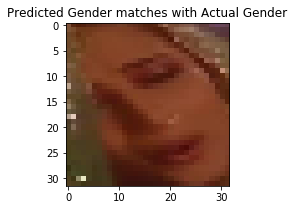

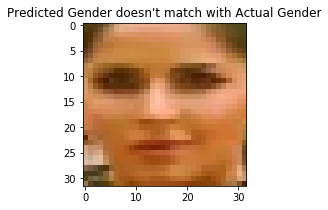

(222, 3072)


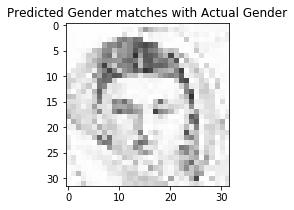

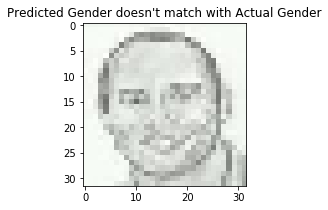

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_imfdb, label_imfdb, test_size=0.33, random_state=42)
main_classifier(X_train,X_test,y_train,y_test,k_imfdb)
X_train, X_test, y_train, y_test = train_test_split(X_cfw, label_cfw, test_size=0.33, random_state=42)
main_classifier(X_train,X_test,y_train,y_test,k_cfw)
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.  

In [67]:
def print_table(ans):
    newlist = sorted(ans, key=itemgetter('accuracy'),reverse=True) 
    data = []
    for i in range(len(newlist)):
        cur = list(newlist[i].values())
        data.append(cur)
    df = pd.DataFrame(data,columns=['Model','Accuracy','training error'])
    print(df)

In [68]:
from sklearn.model_selection import KFold
def k_fold_validation(kpca_tr):
    scores = []
    cv = KFold(n_splits=10, random_state=42, shuffle=False)
    for tr_idx, te_idx in cv.split(kpca_tr):
        X_tr = []
        y_tr = []
        X_te = []
        y_te = []
        model = MLP(hidden_layer_sizes=(500,500))
        for j in tr_idx:
            tr = kpca_tr[j]
            X_tr.append(tr)
            y_tr.append(y_train[j])
        for j in te_idx:
            te = kpca_tr[j]
            X_te.append(te)
            y_te.append(y_train[j])
        model.fit(X_tr, y_tr)
        scores.append(model.score(X_te, y_te))
    return scores

IMFDB
            Model   Accuracy  training error
0         PCA+MLP  91.666667        1.000000
1        KPCA+MLP  90.151515        1.000000
2     LDA+PCA+MLP  90.151515        0.981343
3    LDA+KPCA+SVM  89.393939        0.988806
4     LDA+KPCA+LR  89.393939        0.988806
5   KLDA+KPCA+SVM  89.393939        0.988806
6    KLDA+KPCA+LR  89.393939        0.988806
7     LDA+PCA+SVM  88.636364        0.985075
8      LDA+PCA+LR  88.636364        0.985075
9   KLDA+KPCA+MLP  88.636364        0.985075
10         PCA+LR  87.878788        1.000000
11   LDA+KPCA+MLP  87.878788        0.985075
12       KPCA+SVM  85.606061        0.981343
13        PCA+SVM  84.848485        1.000000
14        KPCA+LR  78.787879        0.847015
15    KLDA+PCA+LR  78.030303        0.861940
16   KLDA+PCA+SVM  77.272727        0.858209
17   KLDA+PCA+MLP  76.515152        0.869403
Accuracy using k-fold on IMFDB
85.44159544159542


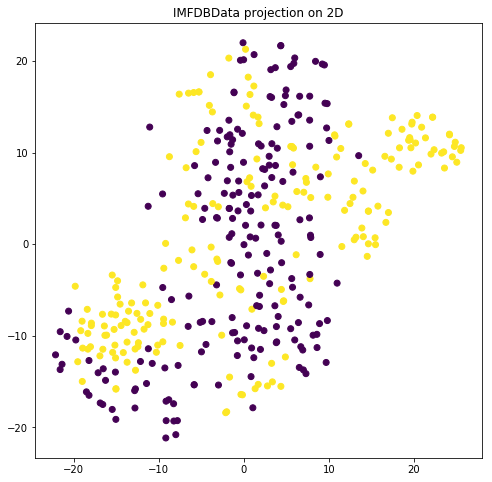

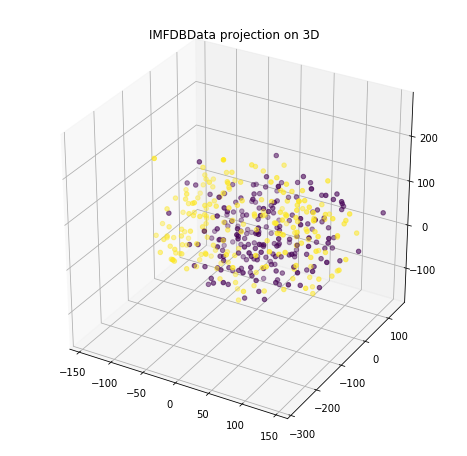

In [71]:
print("IMFDB")
cnt = 1
X_train, X_test, y_train, y_test = train_test_split(X_imfdb, label_imfdb, test_size=0.33, random_state=42)
pca_tr,pca_te,kpca_tr,kpca_te,lda_kpca_tr,lda_kpca_te,lda_pca_tr,lda_pca_te,klda_kpca_tr,klda_kpca_te,klda_pca_tr,klda_pca_te= training(X_train,X_test,y_train,y_test,k_imfdb)
ans = []
run_extension(pca_tr,pca_te,y_train,y_test,"PCA")
run_extension(kpca_tr,kpca_te,y_train,y_test,"KPCA")
run_extension(lda_kpca_tr,lda_kpca_te,y_train,y_test,"LDA+KPCA")
run_extension(lda_pca_tr,lda_pca_te,y_train,y_test,"LDA+PCA")
run_extension(klda_kpca_tr,klda_kpca_te,y_train,y_test,"KLDA+KPCA")
run_extension(klda_pca_tr,klda_pca_te,y_train,y_test,"KLDA+PCA")
ans_imfdb_ext = ans
print_table(ans_imfdb_ext)
scores = k_fold_validation(kpca_tr)
print("Accuracy using k-fold on IMFDB" )
accuracy = (np.mean(scores))*100
print(accuracy)
tnse = kpca_tnse(X_imfdb,k_imfdb)
compute_TNSE(tnse,label_imfdb,2,"IMFDB")
compute_TNSE(tnse,label_imfdb,3,"IMFDB")


CFW
            Model   Accuracy  training error
0         PCA+MLP  88.288288        1.000000
1        KPCA+SVM  85.585586        1.000000
2        KPCA+MLP  85.135135        1.000000
3    LDA+KPCA+SVM  85.135135        0.986667
4     LDA+KPCA+LR  85.135135        0.988889
5    KLDA+KPCA+LR  85.135135        0.988889
6   KLDA+KPCA+SVM  84.684685        0.986667
7         PCA+SVM  83.783784        1.000000
8    LDA+KPCA+MLP  83.783784        0.982222
9   KLDA+KPCA+MLP  83.783784        0.982222
10         PCA+LR  82.882883        1.000000
11     LDA+PCA+LR  81.531532        0.986667
12    LDA+PCA+SVM  81.081081        0.986667
13    LDA+PCA+MLP  81.081081        0.986667
14        KPCA+LR  80.630631        0.873333
15   KLDA+PCA+MLP  77.027027        0.940000
16    KLDA+PCA+LR  76.576577        0.935556
17   KLDA+PCA+SVM  75.675676        0.933333
Accuracy using k-fold on CFW
87.55555555555557


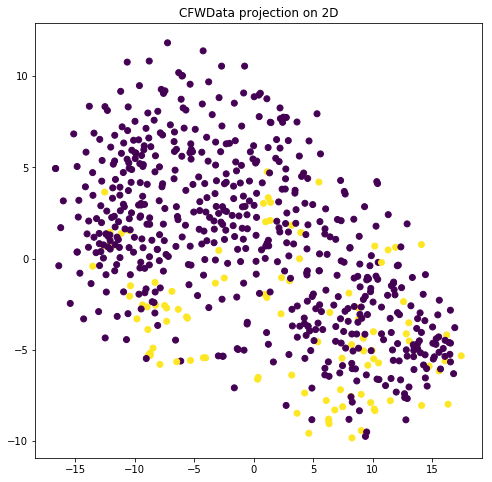

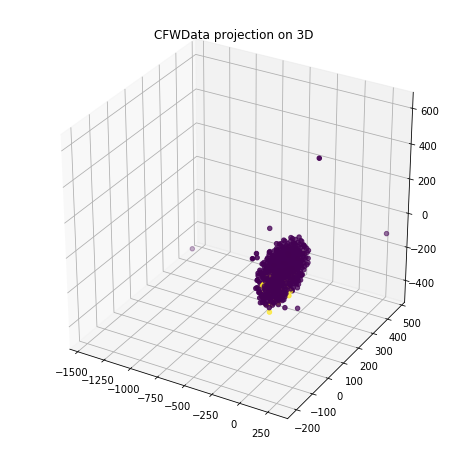

In [72]:
print("CFW")
cnt = 2
X_train, X_test, y_train, y_test = train_test_split(X_cfw, label_cfw, test_size=0.33, random_state=42)
pca_tr,pca_te,kpca_tr,kpca_te,lda_kpca_tr,lda_kpca_te,lda_pca_tr,lda_pca_te,klda_kpca_tr,klda_kpca_te,klda_pca_tr,klda_pca_te= training(X_train,X_test,y_train,y_test,k_cfw)
ans = []
run_extension(pca_tr,pca_te,y_train,y_test,"PCA")
run_extension(kpca_tr,kpca_te,y_train,y_test,"KPCA")
run_extension(lda_kpca_tr,lda_kpca_te,y_train,y_test,"LDA+KPCA")
run_extension(lda_pca_tr,lda_pca_te,y_train,y_test,"LDA+PCA")
run_extension(klda_kpca_tr,klda_kpca_te,y_train,y_test,"KLDA+KPCA")
run_extension(klda_pca_tr,klda_pca_te,y_train,y_test,"KLDA+PCA")
ans_cfw_ext = ans
print_table(ans_cfw_ext)
scores = k_fold_validation(kpca_tr)
print("Accuracy using k-fold on CFW")
accuracy = (np.mean(scores))*100
print(accuracy)
tnse = kpca_tnse(X_cfw,k_cfw)
compute_TNSE(tnse,label_cfw,2,"CFW")
compute_TNSE(tnse,label_cfw,3,"CFW")

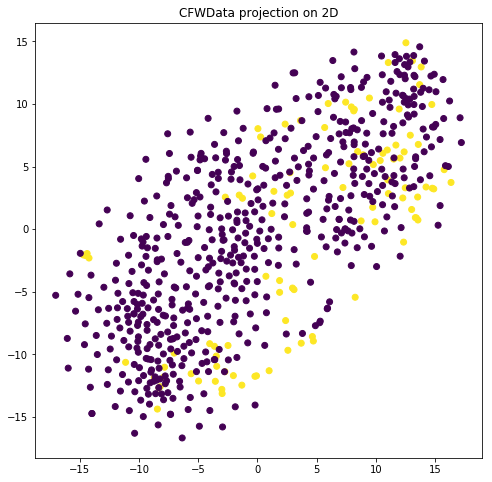

In [73]:
tnse = kpca_tnse(X_cfw,k_cfw,"linear",5)
compute_TNSE(tnse,label_cfw,2,"CFW")

In [ ]:
print(np.shape(tnse))